F1 and bal acc for models w/o CP 
- to isolate effects and see if CP causes the worse performance metrics 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, balanced_accuracy_score
from joblib import load
import yaml

In [9]:
# Helper to build subgroup annotations
def build_subgroup_annotations(y_test, X_test_full):
    df = pd.DataFrame(index=X_test_full.index)
    df['true_label'] = y_test
    df['frau1'] = X_test_full['frau1']
    df['nongerman'] = np.where(X_test_full['maxdeutsch1'] == 0, 1, 0)
    if 'maxdeutsch.Missing.' in X_test_full.columns:
        df.loc[X_test_full['maxdeutsch.Missing.'] == 1, 'nongerman'] = np.nan
    df['nongerman_male'] = np.where((df['nongerman'] == 1) & (df['frau1'] == 0), 1, 0)
    df['nongerman_female'] = np.where((df['nongerman'] == 1) & (df['frau1'] == 1), 1, 0)
    df = df.dropna(subset=['nongerman'])
    return df

In [3]:
# Load universe definitions from YAML
with open("universes.yaml") as f:
    universes = yaml.safe_load(f)

In [4]:
# Determine unique model & feature_set combinations (each requires one model)
unique_combos = {(cfg["model"], cfg["feature_set"]) for cfg in universes}

In [5]:
X_test_f = pd.read_csv("./output/X_test_f.csv")
X_test_s = pd.read_csv("./output/X_test_s.csv")
y_test = pd.read_csv("./output/y_test.csv").iloc[:,0]

In [10]:
y_test = y_test.loc[X_test_f.index]  # align
subgroup_df = build_subgroup_annotations(y_test, X_test_f)

In [ ]:
#feature_sets_test = {
#    "with_protected": X_test_f,
#    "without_protected": X_test_s
#}

In [11]:
metrics_records = []
group_columns = ["Overall", "frau1", "nongerman", "nongerman_male", "nongerman_female"]


In [16]:
for model_type, feature_flag in unique_combos:
    universe_id = f"{model_type}_{feature_flag}"
    model_path = f"./models/{universe_id}.joblib"
    model = load(model_path)

    X_eval = X_test_f if feature_flag == "with_protected" else X_test_s
    y_probs = model.predict_proba(X_eval)[:, 1]

    #thresholds = {
    #    "Top 10%": np.quantile(y_probs, 0.9),
    #    "Top 25%": np.quantile(y_probs, 0.75)
    #}

    thresholds = {
        "Top 15%": np.quantile(y_probs, 0.85),
        "Top 30%": np.quantile(y_probs, 0.70)
    }

    for label, thresh in thresholds.items():
        y_preds = (y_probs >= thresh).astype(int)

        for group in group_columns:
            if group == "Overall":
                y_g = subgroup_df['true_label']
                y_p = y_preds[subgroup_df.index]
            else:
                mask = subgroup_df[group] == 1
                y_g = subgroup_df['true_label'][mask]
                y_p = y_preds[subgroup_df.index][mask]

            if len(y_g) > 0:
                metrics_records.append({
                    "Universe": universe_id,
                    "Model": model_type,
                    "FeatureSet": feature_flag,
                    "Subgroup": group,
                    "Threshold": label,
                    "F1": f1_score(y_g, y_p),
                    "Balanced Accuracy": balanced_accuracy_score(y_g, y_p)
                })


In [17]:
# Create DataFrame
metrics_df = pd.DataFrame(metrics_records)

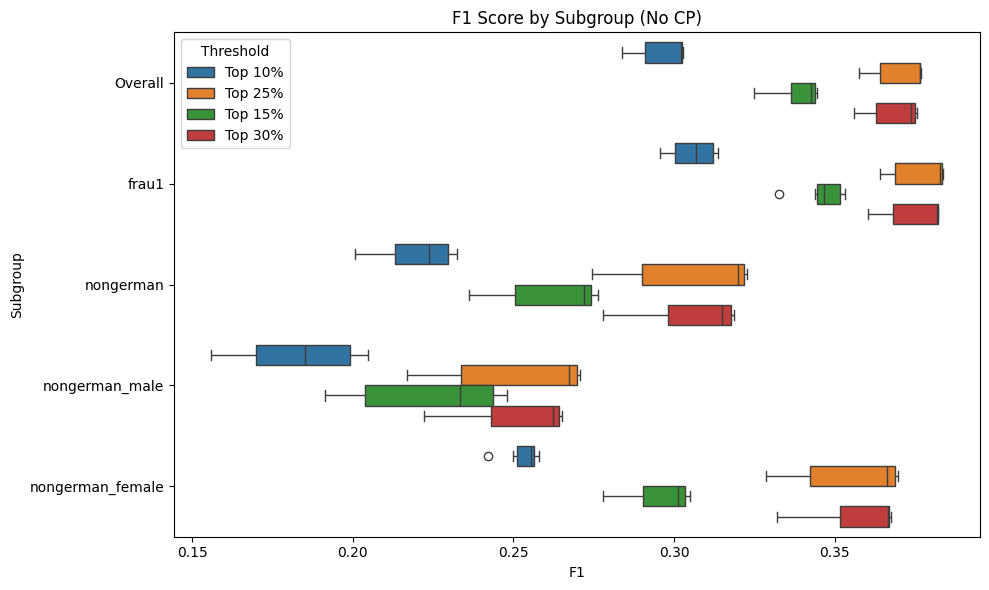

In [18]:
# Plot F1
plt.figure(figsize=(10, 6))
sns.boxplot(data=metrics_df, x="F1", y="Subgroup", hue="Threshold")
plt.title("F1 Score by Subgroup (No CP)")
plt.tight_layout()
plt.show()

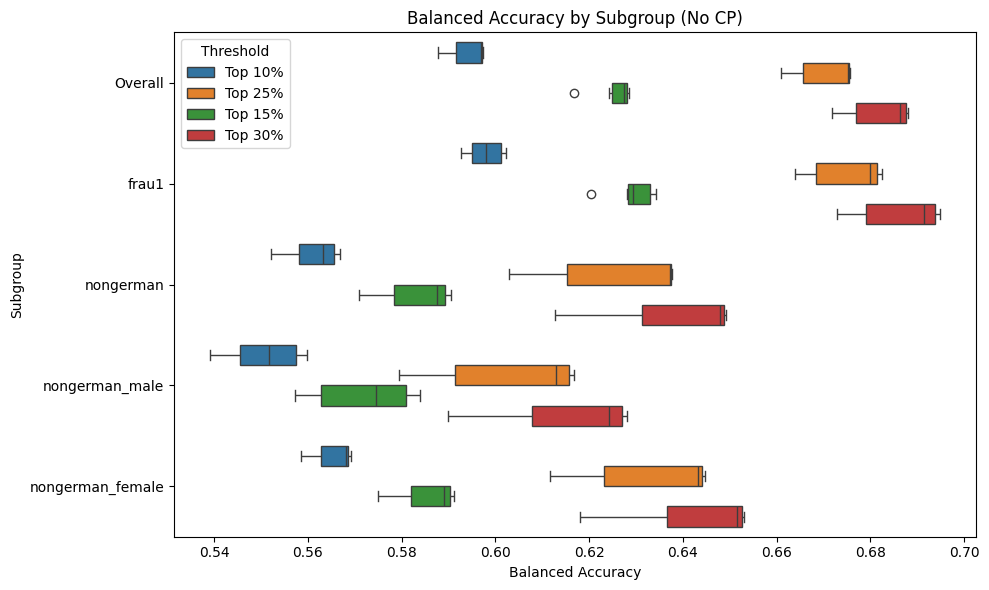

In [19]:
# Plot Balanced Accuracy
plt.figure(figsize=(10, 6))
sns.boxplot(data=metrics_df, x="Balanced Accuracy", y="Subgroup", hue="Threshold")
plt.title("Balanced Accuracy by Subgroup (No CP)")
plt.tight_layout()
plt.show()